In [317]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

In [318]:
import scipy.io
from datetime import datetime, timedelta
import time
import sys, os
import itertools
import numpy
from collections import deque

In [319]:
matlab_filename = 'realitymining.mat'
print("Loading in matlab data - this takes a while and about 2gb memory")
matlab_obj = scipy.io.loadmat(matlab_filename)
print("Done loading matlab data.")

Loading in matlab data - this takes a while and about 2gb memory
Done loading matlab data.


In [320]:
def validSubjects(allSubjects):
    return [s for s in allSubjects if hasNumeric(s,'mac') and hasNumeric(s,'my_hashedNumber')]


# idDicts: subjects -> {int: subject}, {float: (int, subject)}, {int: (int, subject)}
# First hash is contiguousId: subjectObject
# second hash is macAddress: contiguousId, subjectObject
# third hash is hashedNumber: contiguousId, subjectObject
# because the id dictionaries reference the subject object, we can replace
# the array of subject objects with these dictionaries.

def idDicts(subjects):
    return (dict((i, s) for (i,s) in enumerate(subjects)),
        dict((getNumeric(s,'mac'), (i, s)) for (i,s) in enumerate(subjects)),
        dict((getNumeric(s, 'my_hashedNumber'), (i, s)) for (i,s) in enumerate(subjects)))

def hasNumeric(obj, field):
    try:
        obj[field][0][0]
        return True
    except:
        return False
    
def getNumeric(obj, field):
    return obj[field][0][0]

def hasArray(obj, field):
    try:
        obj[field][0]
        return True
    except:
        return False


def getArray(obj, field):
    return obj[field][0]

def convertDatetime(dt):
    return datetime.fromordinal(int(dt)) + timedelta(days=dt%1) - timedelta(days=366) - timedelta(hours=5)

In [321]:
print('Extracting valid subjects and creating id dictionaries.')
subjects = validSubjects(matlab_obj['s'][0])
idDictionaries = idDicts(subjects)

Extracting valid subjects and creating id dictionaries.


In [322]:
def createSMSDataset(idDictionaries):
#     startDate = 1095984000
#     endDate = 1105142400

#    this data contains the subject records as well
    idDict, macDict, hashNumDict = idDictionaries

    events = []
    for subjectId, subject in idDict.items():
        if hasArray(subject, 'comm_sms_date'):
            events.extend([[subjectId, convertDatetime(float(event))] for event in subject['comm_sms_date']])
    print("%d total comm events" % len(events))
            
    return events

In [323]:
SMSevents = createSMSDataset(idDictionaries)

5269 total comm events


In [371]:
SMSevents[0:10]

[[0, datetime.datetime(2004, 8, 3, 18, 33, 36, 999996)],
 [0, datetime.datetime(2004, 8, 4, 9, 5, 10, 2)],
 [0, datetime.datetime(2004, 8, 4, 9, 5, 43, 999998)],
 [0, datetime.datetime(2004, 8, 6, 23, 6, 25, 999995)],
 [0, datetime.datetime(2004, 8, 18, 21, 15, 31, 999997)],
 [0, datetime.datetime(2004, 8, 19, 9, 3, 0, 3)],
 [0, datetime.datetime(2004, 8, 23, 7, 30, 32, 999995)],
 [0, datetime.datetime(2004, 8, 26, 22, 7, 36, 1)],
 [0, datetime.datetime(2004, 8, 27, 21, 28, 49)],
 [0, datetime.datetime(2004, 8, 29, 15, 4, 33, 999996)]]

In [324]:
def create_loc_Dataset(idDictionaries):
#     startDate = 1095984000
#     endDate = 1105142400

#    this data contains the subject records as well
    idDict, macDict, hashNumDict = idDictionaries
    
    events = []
    for subjectId, subject in idDict.items():
        if hasArray(subject, 'locs'):
            for event in subject['locs']:
                try: 
                    timeplace = list(event)
                    time = convertDatetime(timeplace[0])
                    place = timeplace[1]
                    events.extend([[subjectId, time, place]])
                except:
                    pass
    print("%d total loc events" % len(events))
                
    return events

In [325]:
loc_events = create_loc_Dataset(idDictionaries)

3087363 total loc events


In [337]:
le = np.array(loc_events)

In [344]:
le[:,0]

array([0, 0, 0, ..., 89, 89, 89], dtype=object)

In [358]:
print(len(le[np.where(le[:,0]==0)]))

80910


In [367]:
len(np.unique(le[np.where(le[:,0]==0)][:,2]))

1745

In [351]:
smse = np.array(SMSevents)

In [370]:
smse[np.where(smse[:,0]==0)]

array([[0, datetime.datetime(2004, 8, 3, 18, 33, 36, 999996)],
       [0, datetime.datetime(2004, 8, 4, 9, 5, 10, 2)],
       [0, datetime.datetime(2004, 8, 4, 9, 5, 43, 999998)],
       [0, datetime.datetime(2004, 8, 6, 23, 6, 25, 999995)],
       [0, datetime.datetime(2004, 8, 18, 21, 15, 31, 999997)],
       [0, datetime.datetime(2004, 8, 19, 9, 3, 0, 3)],
       [0, datetime.datetime(2004, 8, 23, 7, 30, 32, 999995)],
       [0, datetime.datetime(2004, 8, 26, 22, 7, 36, 1)],
       [0, datetime.datetime(2004, 8, 27, 21, 28, 49)],
       [0, datetime.datetime(2004, 8, 29, 15, 4, 33, 999996)],
       [0, datetime.datetime(2004, 8, 29, 15, 50, 4, 4)],
       [0, datetime.datetime(2004, 8, 29, 15, 57, 31, 4)],
       [0, datetime.datetime(2004, 8, 29, 21, 7, 42, 2)],
       [0, datetime.datetime(2004, 8, 29, 22, 4, 6, 999998)],
       [0, datetime.datetime(2004, 8, 31, 14, 37, 58, 999997)],
       [0, datetime.datetime(2004, 8, 31, 14, 39, 7)],
       [0, datetime.datetime(2004, 8, 31, 

In [491]:
SMSregressiondict = {}

for user in range(0,89):

    user_loc_events = le[np.where(le[:,0]==user)]
    user_SMSevents = smse[np.where(smse[:,0]==user)]

    for loc in range(0, len(user_loc_events)):
        if user_loc_events[loc][2] not in SMSregressiondict.keys():
            SMSregressiondict[user_loc_events[loc][2]] = 0

    start_loc_ind = 0
    end_loc_ind = len(user_loc_events)

    count_texts = 0
    for text in range(0, len(user_SMSevents)):
        count_texts+=1
        for loc in range(start_loc_ind, end_loc_ind-1):
            if user_loc_events[loc][1] <= user_SMSevents[text][1] and user_loc_events[loc+1][1] > user_SMSevents[text][1]:
                SMSregressiondict[user_loc_events[loc][2]] += 1
                start_loc_ind = loc-1
                break
        if(end_loc_ind == 0):
            break
        if user_SMSevents[text][1] > user_loc_events[end_loc_ind-1][1]:
            SMSregressiondict[user_loc_events[end_loc_ind-1][2]] += 1

#     print(count_texts)

In [492]:
SMSregressiondict

{0.0: 201,
 24127.00111: 84,
 24127.02353: 25,
 24127.02832: 16,
 24127.02351: 1,
 24127.01823: 2,
 24127.17032: 1,
 24127.01822: 1,
 24127.17033: 2,
 24127.00012: 0,
 24127.00013: 56,
 24127.02421: 13,
 24127.00182: 55,
 24124.02081: 9,
 24124.02083: 1,
 5119.40811: 377,
 5119.40332: 178,
 5113.41751: 0,
 5113.40463: 2,
 5113.41752: 0,
 5113.41753: 0,
 5113.40323: 23,
 5113.43633: 6,
 5113.43122: 2,
 5113.40321: 30,
 5113.40322: 11,
 5113.41803: 16,
 5113.41801: 22,
 5123.40352: 0,
 5123.40351: 41,
 5123.40763: 107,
 5123.48732: 1,
 5123.40761: 4,
 5123.40762: 40,
 5123.48731: 0,
 5119.46361: 6,
 5119.60241: 3,
 5119.40793: 10,
 5131.43851: 1,
 5119.42161: 27,
 5119.42171: 0,
 5119.43032: 57,
 5119.60292: 87,
 5119.40333: 38,
 5119.43031: 15,
 5119.43033: 6,
 5119.40313: 2,
 5119.43642: 7,
 5119.40311: 2,
 5119.40331: 26,
 5119.60291: 15,
 5123.44152: 6,
 5119.40312: 152,
 5123.40353: 10,
 5133.44141: 0,
 5119.40792: 1,
 5119.40801: 2,
 5119.40783: 20,
 5119.40812: 2,
 5123.40863: 19,

In [493]:
len(SMSregressiondict)

29276

In [494]:
sum(SMSregressiondict.values())

4903

In [495]:
max(SMSregressiondict.values())

543

In [496]:
locs = np.array(list([i] for i in SMSregressiondict.keys()))

In [497]:
locs

array([[    0.     ],
       [24127.00111],
       [24127.02353],
       ...,
       [36457.33381],
       [36457.33141],
       [36457.33052]])

In [498]:
locs.shape

(29276, 1)

In [499]:
texts = np.array(list(SMSregressiondict.values()))

In [500]:
texts

array([201,  84,  25, ...,   0,   0,   0])

In [501]:
np.sum(texts)

4903

In [502]:
order = np.argsort(np.random.random(texts.shape))

In [503]:
print(texts.shape)

(29276,)


In [504]:
n = 903
train_data = locs[order][0:n]
train_labels = texts[order][0:n]

In [505]:
test_data = locs[order][n:texts.shape[0]]
test_labels = texts[order][n:texts.shape[0]]

In [506]:
print("Training set: {}".format(train_data.shape))
print("Testing set:  {}".format(test_data.shape))

Training set: (903, 1)
Testing set:  (28373, 1)


In [507]:
# # Test data is *not* used when calculating the mean and std

# mean = train_data.mean(axis=0)
# std = train_data.std(axis=0)
# train_data = (train_data - mean) / std
# test_data = (test_data - mean) / std

# print(train_data[0])  # First training sample, normalized

In [508]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [509]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

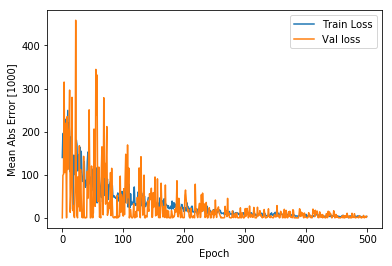

In [510]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
#     plt.ylim([0, 800])

plot_history(history)


.....................

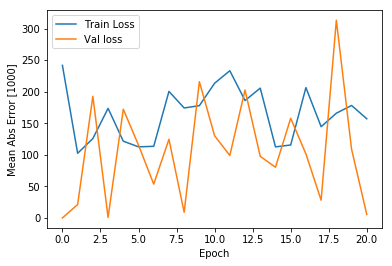

In [511]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [512]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=1)

print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

28373/28373 [==============================] - 1s 34us/step
Testing set Mean Abs Error: 5718.19


(-2611.3055951308243, 54859.45818513082)

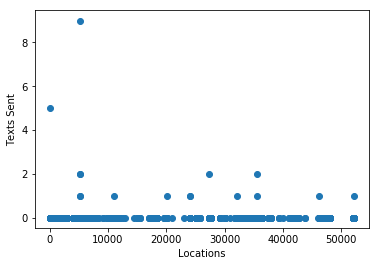

In [513]:
plt.scatter(train_data, train_labels)
plt.xlabel('Locations')
plt.ylabel('Texts Sent')
# plt.axis('equal')
plt.xlim(plt.xlim())
# plt.ylim([-10,250])

(-2937.135442630824, 61679.64716263082)

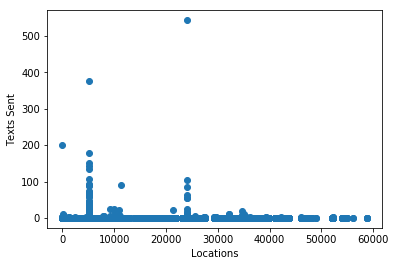

In [514]:
plt.scatter(test_data, test_labels)
plt.xlabel('Locations')
plt.ylabel('Texts Sent')
# plt.axis('equal')
plt.xlim(plt.xlim())
# plt.ylim([-10,600])

(-200, 200)

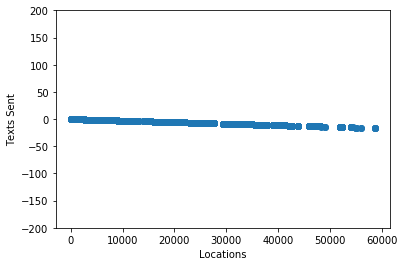

In [515]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_data, test_predictions)
plt.xlabel('Locations')
plt.ylabel('Texts Sent')
# plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim([-200,200])

In [412]:
test_predictions[0]

0.21922123

In [460]:
int(32.99)

32